This homework will guide you through a complete additive model analysis of a time series and familiarize you with the (fairly new) [Facebook Prophet](https://facebook.github.io/prophet/) package for time series analysis. 

Prophet simplifies the implementation of analysis like "Structural Time Series modeling" and/or "Bayesian dynamic linear model": similarly to the ARMA family of models, these models attempt to recreate (and predict) a time series by linearly combining variouos components: trends, seasonalities, but also regression on exogenous variables. In this case, we will see if Uber rides area affected by weather, in additional to trends and seasonality. 

Under the hood, the model will implement an optimization to find the best fit parameters for each component (mostly the relative amplitude of each component) in a Bayesian framework, either as a direct optimization which is possible since the model is linear, or by MCMC (https://github.com/facebook/prophet/issues/669)

Note that the 4 models you will create build incrementally: you are always adding one more piece of a model to the previous one (even when it is not explicitly stated that the new model contains all the components of the previous ones:
- Model 1: trend and seasonality
- Model 2: trend, seasonality, and exogenous weather variables
- Model 3: trend, seasonality, exogenous weather variables, holidays
- Model 4: trend, seasonality, exogenous weather variables, holidays, MCMC implementation (same model, different optimization)



In [1]:
import pandas as pd
import pylab as pl
import fbprophet
from fbprophet import Prophet
from fbprophet import diagnostics
from fbprophet.diagnostics import cross_validation
from wwo_hist import retrieve_hist_data

pd.set_option('display.max_columns', 16)
pl.style.use("https://raw.githubusercontent.com/fedhere/MLTSA_FBianco/master/fbb.mplstyle")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


 
# DATA ANALYSIS 0: we will use the package Prohpet, created by facebook for time series analysis. 
Install the package and import it. The model that you will use is Prophet. Also import the diagnostics package from fbprophet


# 1. DATA ACQUISITION 1: write a for loop that extracts files from the repository https://github.com/fivethirtyeight/uber-tlc-foil-response. 

There are a number of csv files in the repository, and a zip file. Read in within the loop the 6 csv files representing uber pickup deives from April to September 2014. This can be done with a for loop iterating in a container that contains the apporopriate string identified in the file names (e.g. 'apr' for April) and composes the string using an immutable root, the month name, and the immutable ending of the file. Remember to read in the raw files. Remember that ```pd_read_csv ()``` accepts URLs, so you do not have to download the data.

At the end you need the data to be appended into a single datafraom (note: appended, i.e. concatenated, not merged.) You can achieve this in many ways, an easy (and a bit lazy one) is to append each file read in as a dataframe to a list and use ```pd.concat(list)``` to concatenate them into a single dataframe.

In [2]:
pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-apr14" + ".csv")

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
564511,4/30/2014 23:22:00,40.7640,-73.9744,B02764
564512,4/30/2014 23:26:00,40.7629,-73.9672,B02764
564513,4/30/2014 23:31:00,40.7443,-73.9889,B02764
564514,4/30/2014 23:32:00,40.6756,-73.9405,B02764


In [0]:
a = []
for month in ['apr','may', 'jun', 'jul','aug','sep']:
    a.append(pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/uber-tlc-foil-response/master/uber-trip-data/uber-raw-data-" + month + "14.csv"))



In [4]:
uberrides =  pd.concat(a)
print(uberrides)

                  Date/Time      Lat      Lon    Base
0          4/1/2014 0:11:00  40.7690 -73.9549  B02512
1          4/1/2014 0:17:00  40.7267 -74.0345  B02512
2          4/1/2014 0:21:00  40.7316 -73.9873  B02512
3          4/1/2014 0:28:00  40.7588 -73.9776  B02512
4          4/1/2014 0:33:00  40.7594 -73.9722  B02512
...                     ...      ...      ...     ...
1028131  9/30/2014 22:57:00  40.7668 -73.9845  B02764
1028132  9/30/2014 22:57:00  40.6911 -74.1773  B02764
1028133  9/30/2014 22:58:00  40.8519 -73.9319  B02764
1028134  9/30/2014 22:58:00  40.7081 -74.0066  B02764
1028135  9/30/2014 22:58:00  40.7140 -73.9496  B02764

[4534327 rows x 4 columns]


In [0]:
#b = pd.concat(a)
#print(b[0:10])

# DATA PREPARATION 1: convert the dates to datetime and generate a time series of rides/day. 
Note that at this stage this is not the kind of time series you need. You need number of rides per unit time (e.g. per day) and we have timsetamp of each ride. 
To obtain that you can use the ```groupby()``` method of your dataframe. Before that, convert the date time column to ```pd.datetime``` type (this may take a while), then you can use groupby with the "date" attribute, which means grouping by day, and use the method count of groupby to count the number of rides in each group. 

Finally, rename the dataframe so that the number of rides is column ```y``` and the dates are column ```ds``` - this is required by the prophet package that you will use for the enalysis.

** plot the resulting dataframe

In [0]:
uberrides['Date/Time'] = pd.to_datetime(uberrides['Date/Time'])

In [7]:
print(uberrides[0:10])

            Date/Time      Lat      Lon    Base
0 2014-04-01 00:11:00  40.7690 -73.9549  B02512
1 2014-04-01 00:17:00  40.7267 -74.0345  B02512
2 2014-04-01 00:21:00  40.7316 -73.9873  B02512
3 2014-04-01 00:28:00  40.7588 -73.9776  B02512
4 2014-04-01 00:33:00  40.7594 -73.9722  B02512
5 2014-04-01 00:33:00  40.7383 -74.0403  B02512
6 2014-04-01 00:39:00  40.7223 -73.9887  B02512
7 2014-04-01 00:45:00  40.7620 -73.9790  B02512
8 2014-04-01 00:55:00  40.7524 -73.9960  B02512
9 2014-04-01 01:01:00  40.7575 -73.9846  B02512


In [8]:
uberrides.iloc[0]['Date/Time'].date

<function Timestamp.date>

In [0]:
#dt.date just returns the date values of the dataframe
#uberrides['Date/Time'].dt.date

In [0]:
uberbyday = uberrides.groupby(uberrides['Date/Time'].dt.date)

In [0]:
#pd.set_option('display.max_rows', 15)
uberbyday = uberbyday.count()

In [12]:
uberbyday.rename(columns={'Date/Time':'y'},inplace=True)
uberbyday.reset_index(inplace=True)
print(uberbyday)

      Date/Time      y    Lat    Lon   Base
0    2014-04-01  14546  14546  14546  14546
1    2014-04-02  17474  17474  17474  17474
2    2014-04-03  20701  20701  20701  20701
3    2014-04-04  26714  26714  26714  26714
4    2014-04-05  19521  19521  19521  19521
..          ...    ...    ...    ...    ...
178  2014-09-26  37504  37504  37504  37504
179  2014-09-27  39468  39468  39468  39468
180  2014-09-28  29656  29656  29656  29656
181  2014-09-29  29201  29201  29201  29201
182  2014-09-30  33431  33431  33431  33431

[183 rows x 5 columns]


In [13]:
uberbyday.rename(columns={'Date/Time':'ds'},inplace=True)
print(uberbyday)

             ds      y    Lat    Lon   Base
0    2014-04-01  14546  14546  14546  14546
1    2014-04-02  17474  17474  17474  17474
2    2014-04-03  20701  20701  20701  20701
3    2014-04-04  26714  26714  26714  26714
4    2014-04-05  19521  19521  19521  19521
..          ...    ...    ...    ...    ...
178  2014-09-26  37504  37504  37504  37504
179  2014-09-27  39468  39468  39468  39468
180  2014-09-28  29656  29656  29656  29656
181  2014-09-29  29201  29201  29201  29201
182  2014-09-30  33431  33431  33431  33431

[183 rows x 5 columns]


In [14]:
uberbyday.drop(['Lat','Lon','Base'],axis=1, inplace = True)
print(uberbyday)

             ds      y
0    2014-04-01  14546
1    2014-04-02  17474
2    2014-04-03  20701
3    2014-04-04  26714
4    2014-04-05  19521
..          ...    ...
178  2014-09-26  37504
179  2014-09-27  39468
180  2014-09-28  29656
181  2014-09-29  29201
182  2014-09-30  33431

[183 rows x 2 columns]


Text(0, 0.5, 'Number of Rides')

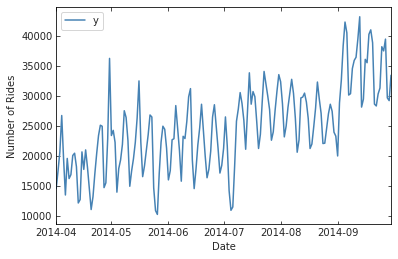

In [15]:
ax = uberbyday.plot(x="ds", y="y");
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")

Figure 1: Number of total rides per day for dates from the start of April to the end of September. Values found by using pandas groupby to find rides per day. Based on visual inspection, there seems to be a general positive trend with a change state in early September. 

# DATA PREPARATION 2: stanardize the data
Subtract the mean and divide by the standard eviation the ```y``` column. Although this is not strictly necessary to work with the Prophet package, it is in general recommanded not to use large numbers in your analysis. furtehrmore, this will convert the target variable to a floating point, which is a better type for regression

In [16]:
#uberbyday.loc[:,"y"].std()
uberbyday['y'].std()

7058.67167597984

In [17]:
#switching variable name in case I screw it up so I don't have to redo creation as test
#uberbyday.loc[:,"y"].std()
#uberbydays = (uberbyday['y'] - uberbyday['y'].mean()) / uberbyday['y'].std()
uberbyday['y'] = (uberbyday['y'] - uberbyday['y'].mean()) / uberbyday['y'].std()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Text(0, 0.5, 'Number of Rides')

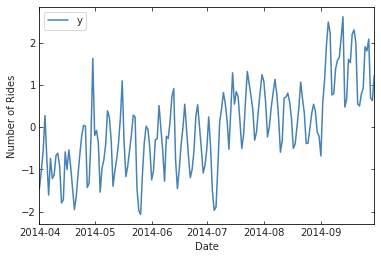

In [18]:
ax = uberbyday.plot(x="ds", y="y");
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")

Figure 2: Same graph as Figure 1, but with the data having its mean number of rides per day subracted and divided by the standard deviation. 

# DATA ANALYSIS fit the uber rides data with the prophet model. 
# MODEL 1: trends and seasonality
The model will look for seasonality and trends automatically. It is a bit of a black box and I dont have a lot of experience with it, but it is really "cutting edge" in this field.
As with any object oriented package, you first need to invoke ```Phrophet()``` to create a model, call it ```simplem```, then fit it to the uber data. Forecast 1 month past the last available datapoint and print the last 5 entries of the resulting dataframe. Plot the forecast, including the uncertainty regions of the forecast and the comonents of the forcast which should be the trend and the weekly seanality. The model should naturally produce these components. If it does not look into the model and the settings by displaying the model methods (e.g. type ```siplemodel.``` and press the tab key.) Remember that ou MUST describe what you see in these plots!


In [19]:
simplem = Prophet()
simplem.fit(uberbyday)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = simplem.make_future_dataframe(periods = 30, freq = "D")
forecast = simplem.predict(future)


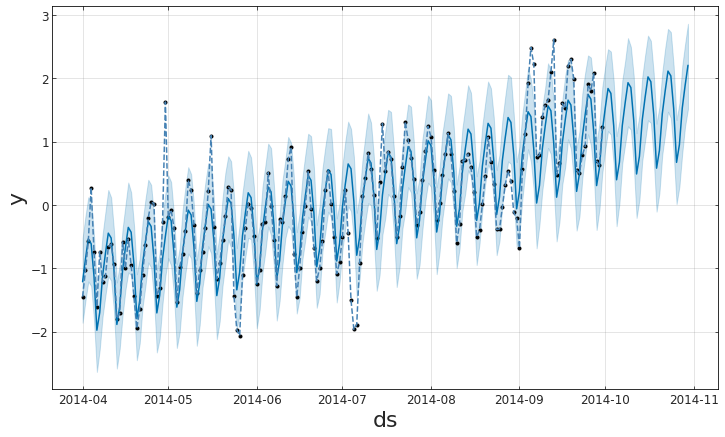

In [21]:

fig = simplem.plot(forecast)
pl.plot(uberbyday.ds, uberbyday.y, '--')


ax = fig.gca()
ax.set_xlabel("ds", size=22)
ax.set_ylabel("y", size=22)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

Figure 3: Plot of the Facebook Prophet model and forecast of the uberride data, given in rides per day. Data is given in black dots, while the model (with uncertainty) is shown with the blue lines and blue shaded region. No modifications to modeling were input, and data was forecast 30 days past last point. Y are the normalized number of rides per day. ds are the dates.

In [22]:
print("The last 5 numbers for the forecast are \n", forecast[-5:])

The last 5 numbers for the forecast are 
             ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
208 2014-10-26  1.529483    0.012682    1.340629     1.529323     1.529639   
209 2014-10-27  1.542582    0.288543    1.603657     1.542413     1.542747   
210 2014-10-28  1.555681    0.815362    2.194374     1.555500     1.555856   
211 2014-10-29  1.568780    1.245680    2.542206     1.568585     1.568969   
212 2014-10-30  1.581878    1.516024    2.859949     1.581672     1.582080   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
208       -0.857826             -0.857826             -0.857826 -0.857826   
209       -0.591815             -0.591815             -0.591815 -0.591815   
210       -0.027561             -0.027561             -0.027561 -0.027561   
211        0.316887              0.316887              0.316887  0.316887   
212        0.622970              0.622970              0.622970  0.622970   

     weekly_lower  weekly_

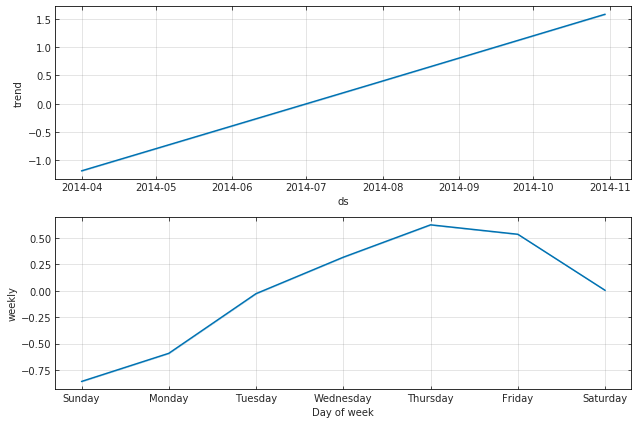

In [23]:
fig2 = simplem.plot_components(forecast)

Figure 4: Plots of the trend and the monthly seasonality for the riders per day for the uberdata. There is a positive growth in the rides over time, and on a weekly basis rides per day grew until Thursday before starting to decline until Sunday. 

# DATA ANALYSIS: model validatoin
 Crossvaliate your model and create a function to evaluate the goodness of fit of your model. 
Use the chisquare per degree of freedom (also calle reduced chi square, note that this quantity has a theoretical expectation value of 1 for a perfect model): the chi square divided by the number of observations.Use 30 days for crossvalidation. The diagnostics function will return all that you need to calculate your reduce chi2. Howeve, we o not have the uncertainties to put them in the formula (we could create them from count statistics, but I wont ask you to) so set the uncertainties to 1. With unerestimated uncertainties this quantity is likely to be less than 1.

You can read about cross valiation for regression here https://robjhyndman.com/hyndsight/tscv/ (but do not set the period=1 or the process would take too long)

In [0]:
def rchi2(ytrue,ypred):
  sigma = 1
  chi2 = np.sum(((ytrue - ypred) / sigma)**2)
  red2 = chi2/len(ytrue)
  return red2

In [25]:
cv = diagnostics.cross_validation(simplem,horizon = '30 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


In [26]:
#yhat is predicted, y is values
#length depends on horizon. 30 = 150. 15 = 255, 25 = 175
print(cv.head)

<bound method NDFrame.head of             ds      yhat  yhat_lower  yhat_upper         y     cutoff
0   2014-07-03  0.474445   -0.040820    1.021180 -0.450615 2014-07-02
1   2014-07-04  0.474838   -0.026170    0.985929 -1.505913 2014-07-02
2   2014-07-05 -0.263004   -0.774074    0.271862 -1.967473 2014-07-02
3   2014-07-06 -1.073989   -1.627407   -0.549601 -1.889129 2014-07-02
4   2014-07-07 -0.722523   -1.240222   -0.189649 -0.920533 2014-07-02
..         ...       ...         ...         ...       ...        ...
145 2014-09-26  1.159241    0.570904    1.735246  1.802925 2014-08-31
146 2014-09-27  0.540499   -0.051664    1.147875  2.081164 2014-08-31
147 2014-09-28 -0.165955   -0.743236    0.444061  0.691101 2014-08-31
148 2014-09-29  0.185216   -0.436631    0.736253  0.626642 2014-08-31
149 2014-09-30  0.710284    0.119413    1.328148  1.225904 2014-08-31

[150 rows x 6 columns]>


In [0]:
#starts at 93
# for count in range(len(uberbyday['ds'])):
#   print(count,uberbyday['ds'][count])

In [28]:
rchi2(cv.y,cv.yhat)

0.4602355257526829

# DATA ACQUISITION 2: dooownload exogenous variable data. 
One may guess that weather would affect the number of rides: a trivial example is that if it rains people are less likely to walk. It might not be that trivial tho, maybe if it  rains people are altogether less likely to go out.

Acquire weather data for NYC for the relevant time period from the www.worldweatheronline.com website through the wwo_hist API. You will have to 1) request a key https://www.worldweatheronline.com/developer/api/, https://www.worldweatheronline.com/developer/signup.aspx ( it is free for <500 requests).
an install and import the ```wwo_hist``` package

Save your key in a separate file and read it in. For example, you can create a file ```my_apis.csv``` in the same folder where you are working and the content of the file can be ```wwo,XXXXXXXXXXXXXXXXX```

This should download a ```New+york,ny.csv``` file which you can then read in. Convert the atetime entry to pd.datetime as you did before and merge the uber reides and the weather dataframe on the date feature. YOud rataframe should now have columns ```y, ds, tempC, precipMM```. You should stanardize the tempC and precipMM features as you did for the number of rides.

Plot each feature.

In [0]:
#!pip install wwo_hist

In [30]:
from google.colab import drive

drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
cd gdrive/My\ Drive

/content/gdrive/My Drive


In [32]:
mkdir hw3

mkdir: cannot create directory ‘hw3’: File exists


In [33]:
cd hw3

/content/gdrive/My Drive/hw3


In [0]:
# import csv
# with open('my_apis.csv','w') as fp:
#   a = csv.writer(fp,delimiter = ',')
#   data = ['wwo','MY API KEY']
#   a.writerow(data)


In [34]:
frequency = 24 #in hours
start_date = '2014-04-01'
end_date = '2014-09-30'
api_key = pd.read_csv("my_apis.csv", header=None, index_col=0).loc["wwo"].values[0]
location_list = ['New+york,ny']
hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True)



Retrieving weather data for New+york,ny


Currently retrieving data for New+york,ny: from 2014-04-01 to 2014-04-30
Time elapsed (hh:mm:ss.ms) 0:00:01.459602
Currently retrieving data for New+york,ny: from 2014-05-01 to 2014-05-31
Time elapsed (hh:mm:ss.ms) 0:00:02.894281
Currently retrieving data for New+york,ny: from 2014-06-01 to 2014-06-30
Time elapsed (hh:mm:ss.ms) 0:00:04.523581
Currently retrieving data for New+york,ny: from 2014-07-01 to 2014-07-31
Time elapsed (hh:mm:ss.ms) 0:00:05.974311
Currently retrieving data for New+york,ny: from 2014-08-01 to 2014-08-31
Time elapsed (hh:mm:ss.ms) 0:00:07.676137
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:09.046773
Currently retrieving data for New+york,ny: from 2014-09-01 to 2014-09-30
Time elapsed (hh:mm:ss.ms) 0:00:10.037191


export New+york,ny completed!




In [0]:
weather = pd.read_csv("New+york,ny.csv")

In [0]:
weather['date_time'] = pd.to_datetime(weather['date_time'])

In [37]:
print(weather[0:10])

   date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  uvIndex.1  \
0 2014-04-01        12         2           0.0     12.8        1          1   
1 2014-04-02        12         4           0.0     12.8        1          1   
2 2014-04-03        13         6           0.0     12.9        1          1   
3 2014-04-04         6         5           0.0      8.1        1          1   
4 2014-04-05        10         3           0.0     12.9        1          1   
5 2014-04-06        12         1           0.0     12.9        1          1   
6 2014-04-07         9         3           0.0     10.7        1          1   
7 2014-04-08        16         7           0.0     10.7        1          1   
8 2014-04-09        14         5           0.0     13.0        1          1   
9 2014-04-10        13         3           0.0     13.1        1          1   

   moon_illumination  ... cloudcover humidity precipMM pressure  tempC  \
0                  5  ...         10       77      0.0  

In [0]:
weather.set_index('date_time',inplace=True)
wbyday = weather[['tempC', 'precipMM']].copy()
wbyday.reset_index(inplace=True)
wbyday.rename(columns={"date_time":"ds"},inplace=True)

In [0]:
wbyday['ds'] = pd.to_datetime(wbyday['ds'])
uberbyday['ds'] = pd.to_datetime(uberbyday['ds'])

In [0]:
uberweather = uberbyday.merge(wbyday)

In [0]:
uberweather['tempC'] = (uberweather['tempC'] - uberweather['tempC'].mean()) / uberweather['tempC'].std()
uberweather['precipMM'] = (uberweather['precipMM'] - uberweather['precipMM'].mean()) / uberweather['precipMM'].std()

In [0]:
#uberweather.set_index('ds',drop=False,inplace=True)

In [43]:
uberweather

,ds,y,tempC,precipMM
0,2014-04-01,-1.449528,-1.959822,-0.484962
1,2014-04-02,-1.034719,-1.959822,-0.430609
2,2014-04-03,-0.577551,-1.766830,-0.484962
3,2014-04-04,0.274309,-3.117776,0.737969
4,2014-04-05,-0.744721,-2.345807,-0.457786
...,...,...,...,...
208,2014-09-28,0.691101,0.742069,-0.484962
209,2014-09-29,0.626642,0.356084,-0.457786
210,2014-09-29,0.626642,0.356084,-0.457786
211,2014-09-30,1.225904,-0.222892,-0.267552


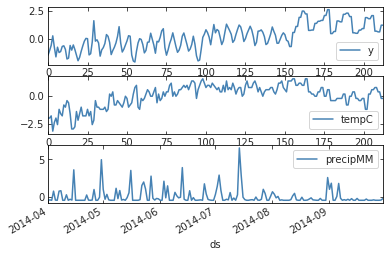

In [44]:
fig, ax = pl.subplots(3)
uberweather.plot(y="y", ax=ax[0])
uberweather.plot(y="tempC", ax=ax[1])
uberweather.plot(x="ds",y="precipMM", ax=ax[2])

Figure 5: Plots of the (normalized) uber rides per day (y), temperature in Celcius for those days, and precipitation in mm for those days, from April to the end of September. 

   # MODEL 2: create a new Prophet model and add to it tempC and precipMM as regressors
Use the model method ```model.add_regressor()```. Call the model ```regrm```. Fit the model and cross valiate it. Plot the 2 models and calculate the reduced chi2 for each model and compare. Note that here you should not forecast, since you do not have the future values of the weather. If you wanted to go through the trouble to get future weather and forecast that is definitely a good extra credit!

In [0]:
regrm = Prophet()

In [46]:
regrm.add_regressor('tempC')
regrm.add_regressor('precipMM')

In [47]:
regrm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


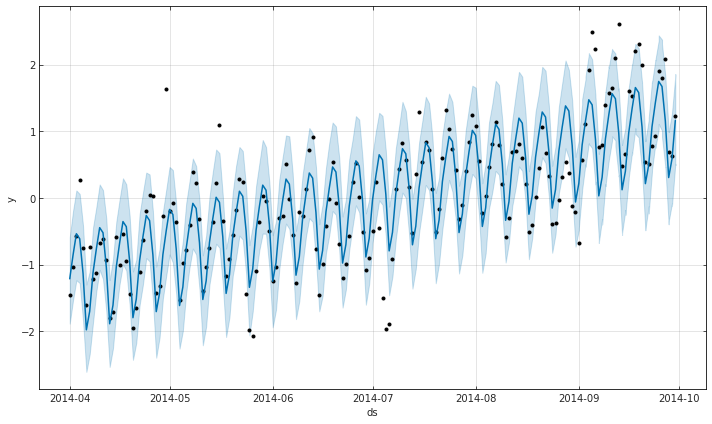

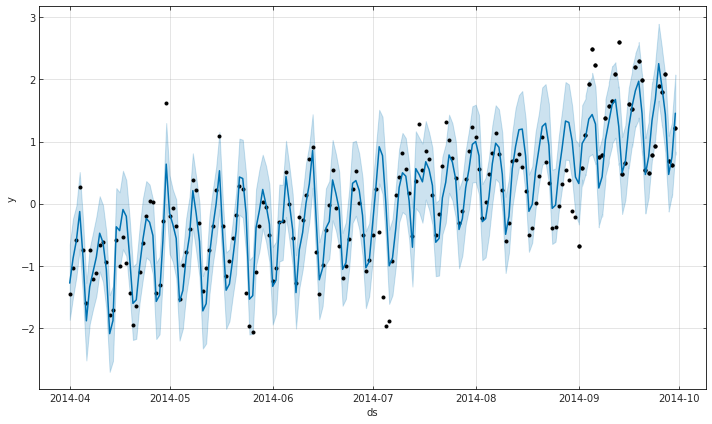

In [48]:
nowcast = regrm.predict(uberweather)
nowcast2 = simplem.predict(uberweather)
simplem.plot(nowcast2)
regrm.plot(nowcast);

Figure 6: Plots of the models Prophet provided for the uber rides per day. The top just takes into consideration date and number of rides. The bottom plot included information on temperature and rainfall. The two models are very similar, and only slight differences in how close data points lie to the model are noticeable. This indicates that adding weather data did not greatly increase our model accuracy. 

...caption...

In [49]:
cv = diagnostics.cross_validation(simplem, horizon = '30 days')
#print(cv.head)
rchi2(cv.y,cv.yhat)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.4602355257526829

In [50]:
cv = diagnostics.cross_validation(regrm, horizon = '30 days')
#print(cv.head)
rchi2(cv.y,cv.yhat)

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


0.47592214974447833

# MODEL 3 add holidays
Holiday of course affect traffic and ridership. Prophoet has very convenient functionality to put in holidays! This a huge simplification of the workflow in timeseries analysis! add holidays for ths us with the model ```model.add_country_holidays()``` which takes argument ```country_name="US"``` in the case of the US. Once again, fit, predict, plot, crossvalidate, calculate and compare the reduced chi2


In [0]:
regholm = Prophet()

In [52]:
regholm.add_regressor('tempC')
regholm.add_regressor('precipMM')


In [53]:
regholm.add_country_holidays("US")

In [54]:
regholm.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


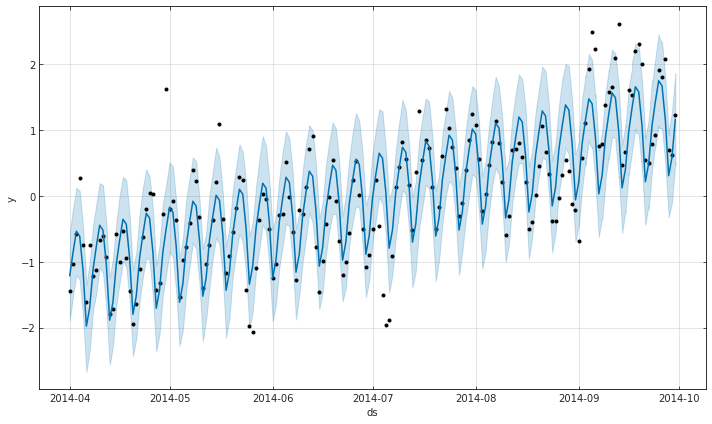

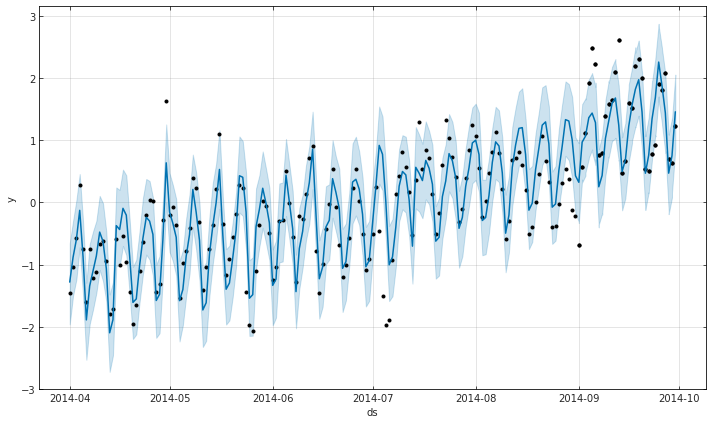

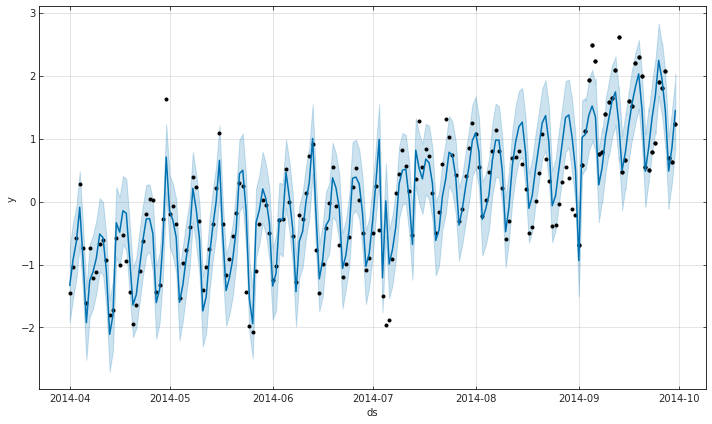

In [55]:
nowcast = simplem.predict(uberweather)
nowcast2 = regrm.predict(uberweather)
nowcast3 = regholm.predict(uberweather)

simplem.plot(nowcast)
regrm.plot(nowcast2)
regholm.plot(nowcast3);

Figure 7: Same as figure 6, but with the bottom plot having both weather and holiday data used in creating the model. There appears to be some better results in incorporating some of the more extreme values of the data into the fit, and narrowing error spread at some points (note 2014-07).  

In [56]:
cv = diagnostics.cross_validation(simplem, horizon = '30 days')
#print(cv.head)
print("Simplem",rchi2(cv.y,cv.yhat))

cv = diagnostics.cross_validation(regrm, horizon = '30 days')
#print(cv.head)
print("regrm",rchi2(cv.y,cv.yhat))

cv = diagnostics.cross_validation(regholm, horizon = '30 days')
#print(cv.head)
print("regholm",rchi2(cv.y,cv.yhat))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00
INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


Simplem 0.4602355257526829


INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


regrm 0.47592214974447833
regholm 0.4208093300350918


Significant drop in chi-squared for Holiday incorporation, which is good (ypred is closer to ydata). 

# MODEL 4: this whole thing can be done with MCMC optimization in a fully bayesian framework. 
Add the argument mcmc_samples=5000 to Propher in your next model and see how it goes. Make the usual plots and calculate the reduced chi2 one last time

In [0]:
regmcmc = Prophet(mcmc_samples = 5000)

In [58]:
regmcmc.add_regressor('tempC')
regmcmc.add_regressor('precipMM')
regmcmc.add_country_holidays("US")

In [59]:
regmcmc.fit(uberweather)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
nowcast = simplem.predict(uberweather)
nowcast2 = regrm.predict(uberweather)
nowcast3 = regholm.predict(uberweather)
nowcast4 = regmcmc.predict(uberweather)

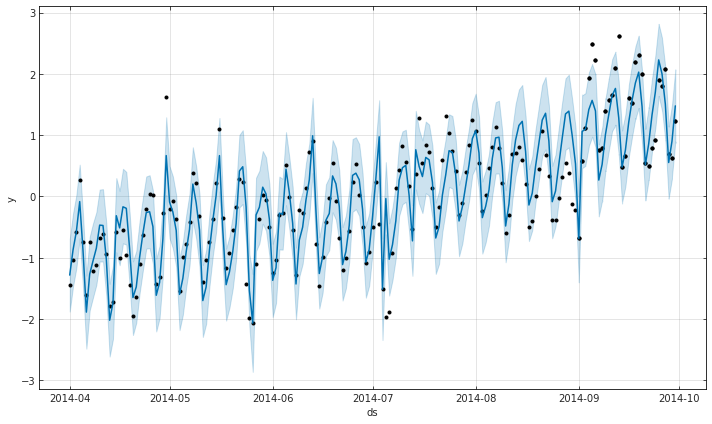

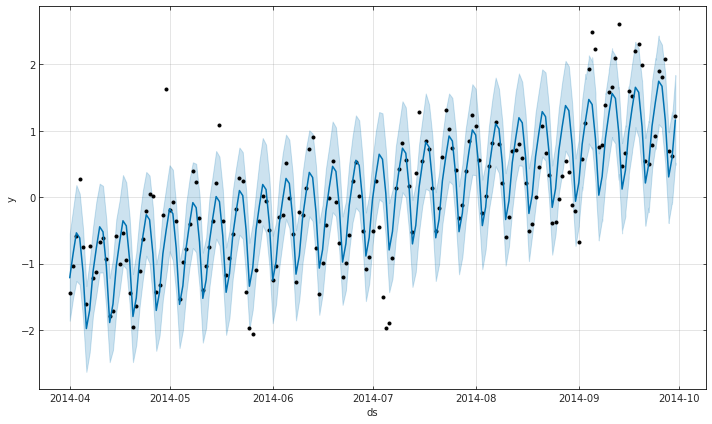

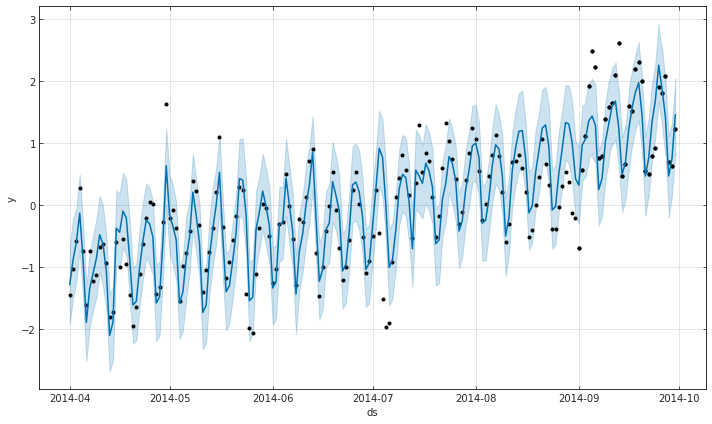

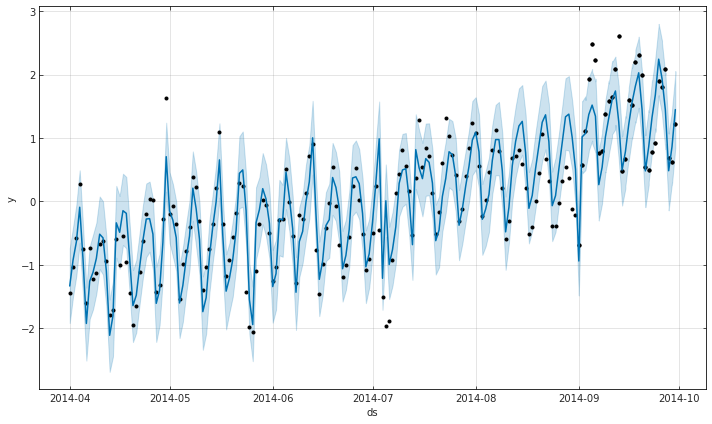

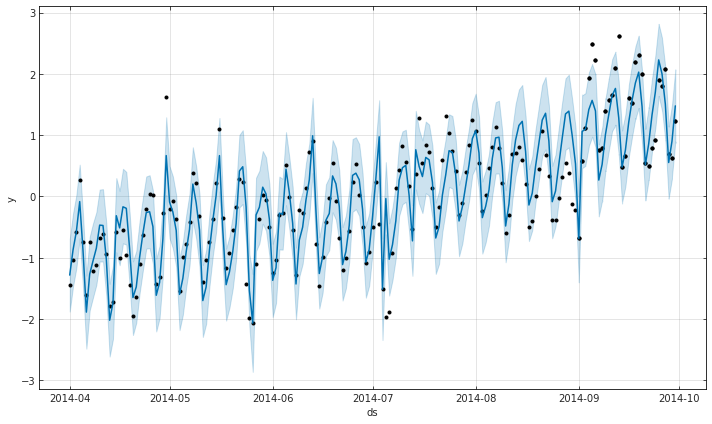

In [61]:
simplem.plot(nowcast)
regrm.plot(nowcast2)
regholm.plot(nowcast3)
regmcmc.plot(nowcast4)

Figure 8: Same as figure 7, but with the bottom graph having a fit model with weather and holidays calculated using mcmc with 5000 walkers to explore the space. Computation time for this fit was longer. Some small improvements seem to have been made in reaching some extreme points, but nothing drastic. 

In [62]:
cv = diagnostics.cross_validation(simplem, horizon = '30 days')
#print(cv.head)
print("Simplem",rchi2(cv.y,cv.yhat))

cv = diagnostics.cross_validation(regrm, horizon = '30 days')
#print(cv.head)
print("regrm",rchi2(cv.y,cv.yhat))

cv = diagnostics.cross_validation(regholm, horizon = '30 days')
#print(cv.head)
print("regholm",rchi2(cv.y,cv.yhat))

cv = diagnostics.cross_validation(regmcmc,horizon = "30 days")
print("regmcmc",rchi2(cv.y,cv.yhat))

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00
INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


Simplem 0.4602355257526829


INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


regrm 0.47592214974447833


INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-07-02 00:00:00 and 2014-08-31 00:00:00


regholm 0.4208093300350918
regmcmc 0.4886301112001155


Unfortunately, it looks like the MCMC had the worst fit with the highest rchi2 out of the models tested. Its possible this could be improved by giving a good starting point or increasing the number of walkers. 

# Extra Credit
There are two packages with similar functionalities. As extra credit, repeat some of the steps of this analysis with either: Tensorflow timeseries modeling https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html or https://github.com/wwrechard/pydlm